In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import geopandas as gpd
import geoplot
import geoplot.crs as gcrs
from shapely.geometry import Point
from geopy import distance

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
import re


import warnings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
scaler = StandardScaler()

In [2]:
# Load data
clean_data = pd.read_csv('data/Ames_HousePrice_cleaned.csv')
address_data = pd.read_csv('data/Ames_HousePrice_Address.csv')
city = gpd.read_file("data/city.geojson")
roads = gpd.read_file("data/roads.geojson")
park = gpd.read_file("data/park.geojson")

roads_df = roads[['highway','geometry']]
roads_motor = roads_df[roads_df['highway']=='motorway']
roads_primary = roads_df[roads_df['highway']=='primary']
roads_secondary = roads_df[roads_df['highway']=='secondary']
# roads_tertiary = roads_df[roads_df['highway']=='tertiary']
# roads_residential = roads_df[roads_df['highway']=='residential']

clean_data = clean_data.merge(address_data[['PID', 'Longitude', 'Latitude']], on = 'PID')
clean_data = clean_data[~clean_data['Longitude'].isna()].copy()
clean_data = clean_data[clean_data['PID']!=908154205]
# clean_data[~clean_data.MSZoning.isin(list(['A', 'C', 'FV', 'I']))]

In [80]:
# Geographic feature clustering
# clean_data_cluster = clean_data[['Longitude', 'Latitude']]
# scaled_features = scaler.fit_transform(clean_data_cluster)
# kmeans = KMeans(init="random", n_clusters=10, n_init=10, max_iter=300, random_state=42)
# kmeans.fit(scaled_features)
# clean_data['cluster'] = kmeans.labels_
# clean_data.to_csv('x_new.csv',index=False)
clean_data_geo = clean_data
# Geographic feature engineering
mainlocs = {"LincolnGrand" : (42.0228613,-93.6202381),
            "GreekCircle" : (42.0203082,-93.643163),
            "OntarioND" : (42.034549,-93.6787169),
            "Stange13" : (42.0352885,-93.644862),
            # "LincolnSD" : (42.0229155,-93.6786829),
            "Grand13" : (42.0345358,-93.6203941),
            "Grand24" : (42.0457363,-93.6205019),
            # "GWHarrison" : (42.0594753,-93.6592406),
            "BloomStange" : (42.0563395,-93.6448835),
            # "Jewel69" : (41.9935311,-93.6102327),
            "IC3069" : (41.9935311,-93.6102327)
            }            

for kw, val in mainlocs.items():
    dist = clean_data_geo.apply(lambda x: distance.distance((x.loc['Latitude'],x.loc['Longitude']), val).miles, axis = 1)
    clean_data_geo['gaudist_%s' %kw] = np.exp(-(dist/1.5)**2)



In [82]:
cl_y = clean_data_geo['SalePrice']
cl_x = clean_data_geo.drop(['PID','SalePrice','LandContour','LotShape','MSSubClass', 'PavedDrive',\
         'GarageType','CentralAir','Electrical','MoSold', 'YrSold','Neighborhood','Longitude', 'Latitude'], axis = 1)
# cl_x['QSF'] = clean_data['OverallQual']*clean_data['GrLivArea']

TypeError: cannot convert the series to <class 'int'>

In [ ]:
cl_x.columns

Index(['GrLivArea', 'MSZoning', 'LotArea', 'LotConfig', 'Neighborhood',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF',
       '2ndFlrSF', 'FullBath', 'BedroomAbvGr', 'KitchenQual', 'Fireplaces',
       'GarageArea', 'OurdoorSpace', 'YrMoSold', 'AgeSold', 'SaleCondition',
       'gaudist_LincolnGrand', 'gaudist_GreekCircle', 'gaudist_OntarioND',
       'gaudist_Grand13', 'gaudist_Grand24', 'gaudist_GWHarrison',
       'gaudist_BloomStange', 'gaudist_IC3069', 'gaudist_LincolnSD',
       'gaudist_Jewel69', 'gaudist_Stange13'],
      dtype='object')

In [ ]:
cl_x_dummies = pd.get_dummies(cl_x, columns=['MSZoning','LotConfig', 'BldgType', 'HouseStyle','MasVnrType', 'ExterQual', \
        'ExterCond', 'Foundation', 'BsmtQual','BsmtCond', 'BsmtExposure',
       'HeatingQC','KitchenQual','SaleCondition','BsmtFinType1','BsmtFinType2'],\
        prefix=['ms','lcf','bt','hs','mvt','eq',\
                'ec','f','bq','bc','be',\
               'hq','kq','sc','b1','b2'], prefix_sep='_',drop_first=True)
               
cl_x_dummies = cl_x_dummies.fillna(0)

trainscore = []
testscore = []
coefs = []
residuals = []
residualratio = []

for i in range(100):
        X_train, X_test, y_train, y_test = train_test_split(cl_x_dummies, cl_y, test_size=0.2, random_state=i, shuffle=True)
        # X_train.to_csv('x_train_dummies.csv',index=False)
        # y_train.to_csv('y_train_dummies.csv',index=False)
        # X_test.to_csv('x_test_dummies.csv',index=False)
        # y_test.to_csv('y_test_dummies.csv',index=False)

        scaler.fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled  = scaler.transform(X_test)

        model  = linear_model.RidgeCV(alphas=np.logspace(-3, 3, 7),normalize=True)
        model.fit(X_train, np.log(y_train))

        trainscore.append(model.score(X_train, np.log(y_train)))
        testscore.append(model.score(X_test, np.log(y_test)))
        coefs.append(model.coef_)
        residuals.append(cl_y - np.exp(model.predict(cl_x_dummies)))
        residualratio.append(cl_y/np.exp(model.predict(cl_x_dummies)))

avetrainscore = np.mean(trainscore)
avetestscore = np.mean(testscore)
averesiduals = np.mean(residuals, axis =0)
averesidualratio = np.mean(residualratio, axis =0)

coef = list(zip(X_train.columns.to_list(), model.coef_.T))
print(avetestscore)
# plt.hist(testscore, bins = np.arange(0.8,0.95,0.005))
# plt.savefig("testscore_without_outlier.svg")


0.92475189787092


In [32]:
housing = clean_data.copy()
housing['residual'] = averesiduals.T
housing['residualratio'] = averesidualratio.T
housing.sort_values('residual')


,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotArea,LotShape,LandContour,LotConfig,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,TotalBsmtSF,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,FullBath,BedroomAbvGr,KitchenQual,Fireplaces,GarageType,GarageArea,PavedDrive,OurdoorSpace,MoSold,YrSold,YrMoSold,AgeSold,SaleCondition,Longitude,Latitude,gaudist_LincolnGrand,gaudist_GreekCircle,gaudist_OntarioND,gaudist_Grand13,gaudist_Grand24,gaudist_GWHarrison,gaudist_BloomStange,gaudist_IC3069,gaudist_LincolnSD,gaudist_Jewel69,gaudist_Stange13,residual,residualratio
1004,528351010,4316,755000,60,RL,21535,IR1,Lvl,Corner,NoRidge,1Fam,2Story,10,6,1994,1995,BrkFace,1170.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,1455.0,Unf,0.0,2444.0,Ex,Y,SBrkr,2444,1872,3,4,Ex,2,Attchd,832.0,Y,432,1,2007,2007.083333,12.083333,Normal,-93.657271,42.051980,0.033086,0.094622,0.305965,0.106042,0.187759,0.883821,0.801973,0.000053,0.097507,0.000053,0.462562,-132106.931110,0.851229
274,533350090,2944,150000,60,RL,24572,IR1,Lvl,CulDSac,Veenker,1Fam,2Story,9,3,1977,1977,BrkFace,1050.0,Gd,Gd,CBlock,Gd,TA,No,GLQ,410.0,Unf,0.0,994.0,TA,Y,SBrkr,1599,1345,2,3,Gd,1,Attchd,864.0,Y,226,6,2008,2008.500000,31.500000,Family,-93.655582,42.036729,0.153016,0.471247,0.527396,0.230609,0.198008,0.329187,0.387201,0.001709,0.356301,0.001709,0.869702,-113588.963812,0.570328
510,528108020,2042,253293,20,RL,12704,Reg,Lvl,Inside,NridgHt,1Fam,1Story,8,5,2008,2009,BrkFace,306.0,Ex,TA,PConc,Ex,TA,No,Unf,0.0,Unf,0.0,2042.0,Ex,Y,SBrkr,2042,0,2,3,Ex,1,Attchd,1390.0,Y,90,8,2009,2009.666667,0.666667,Partial,-93.654144,42.062992,0.008549,0.018333,0.088661,0.047169,0.140679,0.944858,0.823229,0.000004,0.016429,0.000004,0.177962,-93857.945282,0.729733
1979,532478020,2014,275000,20,RL,15676,IR1,Low,Inside,Veenker,1Fam,1Story,8,8,1980,1980,BrkFace,115.0,Gd,Gd,CBlock,Gd,Gd,Gd,ALQ,1733.0,Rec,92.0,2014.0,Gd,Y,SBrkr,2014,0,2,2,Gd,2,Attchd,864.0,Y,717,4,2009,2009.333333,29.333333,Normal,-93.660327,42.037236,0.097420,0.385443,0.661534,0.150820,0.132820,0.350467,0.348836,0.000913,0.435753,0.000913,0.748693,-82164.226705,0.770083
1730,535125010,2207,180000,20,RL,19900,Reg,Lvl,Inside,NAmes,1Fam,1Story,7,5,1970,1989,BrkFace,287.0,TA,TA,CBlock,Gd,TA,Gd,GLQ,912.0,Unf,0.0,1947.0,TA,Y,SBrkr,2207,0,2,3,TA,1,Attchd,576.0,Y,301,7,2010,2010.583333,21.583333,Normal,-93.614307,42.049514,0.213244,0.061693,0.004727,0.595380,0.927418,0.075452,0.301778,0.001288,0.001706,0.001288,0.217256,-77153.012053,0.700028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,528110070,1973,395000,20,RL,14226,Reg,Lvl,Corner,NridgHt,1Fam,1Story,8,5,2006,2006,BrkFace,375.0,Gd,TA,PConc,Gd,TA,Av,Unf,0.0,Unf,0.0,1935.0,Gd,Y,SBrkr,1973,0,2,3,Gd,1,Attchd,895.0,Y,360,7,2007,2007.583333,1.583333,Partial,-93.656286,42.062408,0.007910,0.019159,0.107000,0.042432,0.123165,0.971928,0.793868,0.000004,0.020403,0.000004,0.180759,98036.424677,1.330242
680,916252170,1295,230000,120,RM,8239,IR1,Lvl,Inside,GrnHill,TwnhsE,1Story,7,5,1986,1986,None,0.0,Gd,TA,CBlock,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,Gd,Y,SBrkr,1295,0,2,2,Gd,0,Attchd,312.0,Y,0,11,2006,2006.916667,20.916667,Normal,-93.645586,42.000966,0.170079,0.449795,0.025225,0.043589,0.006846,0.000572,0.001515,0.204053,0.099283,0.204053,0.082527,100615.081325,1.778660
1999,902400110,3608,475000,75,RM,22950,IR2,Lvl,Inside,OldTown,1Fam,2.5Fin,10,9,1892,1993,None,0.0,Gd,Gd,BrkTil,TA,TA,Mn,Unf,0.0,Unf,0.0,1107.0,Ex,Y,SBrkr,1518,1518,2,4,Ex,2,Detchd,840.0,Y,670,6,2006,2006.500000,13.500000,Normal,-93.610438,42.029025,0.824096,0.241389,0.003885,0.834488,0.491446,0.008527,0.051034,0.069446,0.003847,0.069446,0.228210,103082.964599,1.278707
73,911370410,1652,392500,120,RM,55

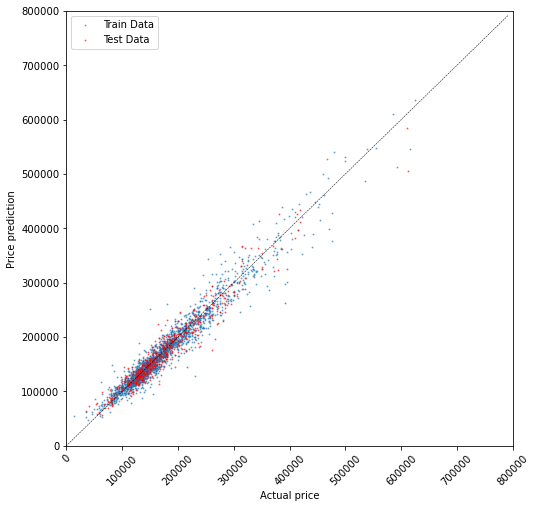

In [7]:
def abline(slope, intercept, ax):
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    ax.plot(x_vals, y_vals, 'k--', linewidth=0.5)

fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(y_train, np.exp(model.predict(X_train)), alpha = 0.5, s = 1, label='Train Data')
ax.scatter(y_test, np.exp(model.predict(X_test)), alpha = 0.5, s = 1, color = 'red', label='Test Data')
abline(1,0,ax)
plt.xlim([0, 800000])
plt.ylim([0, 800000])
plt.xlabel('Actual price')
plt.ylabel('Price prediction')
plt.xticks(rotation = 45)
leg = ax.legend()

plt.show()

fig.savefig("predictresult.svg")

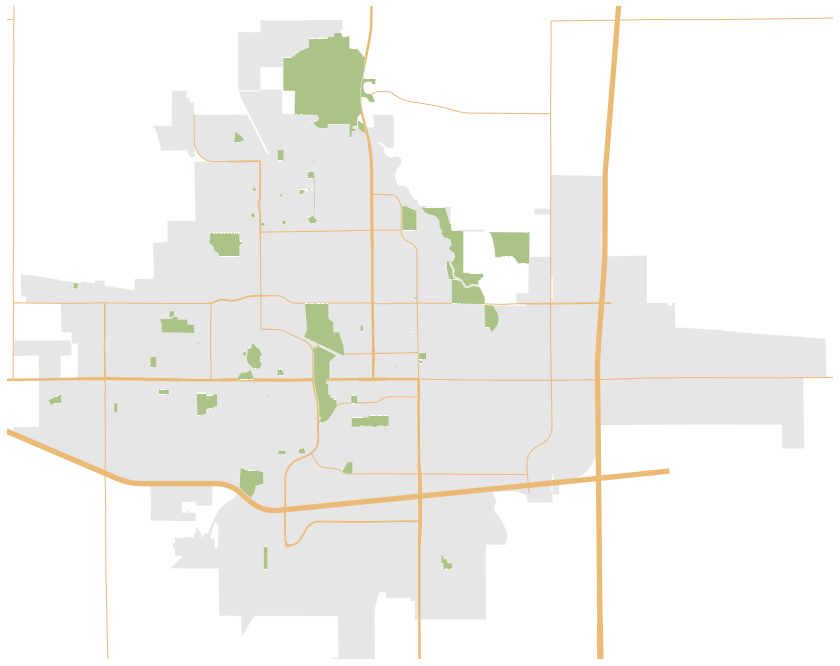

In [100]:
houses = housing.apply(
    lambda srs: Point(float(srs['Longitude']), float(srs['Latitude'])),
    axis='columns'
)
housing['pps'] = housing['SalePrice']/housing['GrLivArea']
houses_geocode = gpd.GeoDataFrame(housing, geometry=houses)

ax = geoplot.polyplot(city, projection=gcrs.AlbersEqualArea(), edgecolor='white', facecolor='#e6e6e6', linewidth=.3, figsize=(16, 12))
geoplot.polyplot(roads_motor, edgecolor='#ebba76', linewidth=4, ax = ax)
geoplot.polyplot(roads_primary, edgecolor='#ebba76', linewidth=2.5, ax = ax)
geoplot.polyplot(roads_secondary, edgecolor='#ebba76', linewidth=1, ax = ax)
# geoplot.polyplot(roads_tertiary, edgecolor='white', linewidth=1, ax = ax)
# geoplot.polyplot(roads_residential, edgecolor='white', linewidth=0.25, ax = ax)
# geoplot.pointplot(houses_geocode, hue='residual',cmap = 'seismic', marker = '.', s = 5, alpha = 1, legend=True, ax=ax)
# geoplot.pointplot(houses_geocode, hue='gaudist_Grand24',cmap = 'cool', marker = '.', s = 5, legend=True, ax=ax)
# geoplot.pointplot(houses_geocode, hue='MSSubClass',cmap = 'jet', marker = '.', s = 5, legend=True, ax=ax)

geoplot.polyplot(park, projection=gcrs.AlbersEqualArea(), edgecolor='white', facecolor='#acc388', linewidth=.3, ax=ax, extent=( -93.70,41.98, -93.52, 42.08))
plt.savefig("map.svg")

In [35]:
xmin, xmax, nx = -93.70, -93.52, 128
ymin, ymax, ny = 41.98, 42.08, 100

x, y = np.linspace(xmin, xmax, nx), np.linspace(ymin, ymax, ny)
X, Y = np.meshgrid(x, y)
X2 = X.reshape(-1)
Y2 = Y.reshape(-1)
coords = pd.DataFrame(zip(X2,Y2))


for kw, val in mainlocs.items():
    dist = coords.apply(lambda x: distance.distance((x[1],x[0]), val).miles, axis = 1)
    coords['gaudist_%s' %kw] = np.exp(-(dist/1.5)**2)



C:\Users\chadd\AppData\Local\Temp\ipykernel_50456\780418172.py:8: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


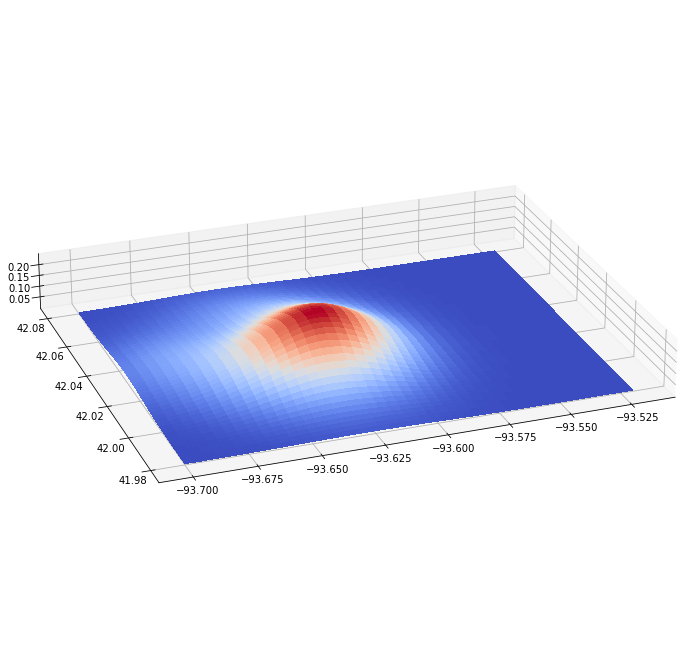

In [50]:
from matplotlib import cm 

coef = np.array(coef)
Z = coords.to_numpy()[:,2:10].astype(float)@coef[19:27,1].astype(float)
Z = Z.reshape(100,128)

fig = plt.figure(figsize=(16, 12))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0.5, alpha = 1, antialiased=False)
ax.view_init(azim=-110, elev=25)
# ax.contour3D(X, Y, Z, 50, cmap='binary')
# ax.view_init(20, 35)
ax.set_box_aspect((1.28, 1, 0.15))
plt.savefig("heat3d.svg")


In [22]:
import plotly.express as px
df = px.data.carshare()
df

,centroid_lat,centroid_lon,car_hours,peak_hour
0,45.471549,-73.588684,1772.750000,2
1,45.543865,-73.562456,986.333333,23
2,45.487640,-73.642767,354.750000,20
3,45.522870,-73.595677,560.166667,23
4,45.453971,-73.738946,2836.666667,19
...,...,...,...,...
244,45.547171,-73.556258,951.416667,3
245,45.546482,-73.574939,795.416667,2
246,45.495523,-73.627725,425.750000,8
247,45.521199,-73.581789,1044.833333,17


In [52]:
import plotly.offline as go_offline
import plotly.graph_objects as go
import plotly.express as px

# CREATING 3D TERRAIN MODEL
fig=go.Figure()
fig.add_trace(go.Scattermapbox(lat = clean_data_geo["Latitude"], lon = clean_data_geo["Longitude"],\
    mode='markers',\
    marker=go.scattermapbox.Marker(size=9)))
fig.add_trace(go.Surface(z=Z,x=X,y=Y, opacity = 0.5))
        
fig.update_layout(
    autosize=True,
    hovermode='closest',
    mapbox=dict(
        accesstoken='pk.eyJ1IjoiY2hhZGxvaCIsImEiOiJja2dkejM3ejIwN3M1MnJ0OTFjaXp0dWkwIn0.2NM6sivklBFKtjRraSoJDg',
        bearing=0,
        center=dict(
            lat=(ymin+ymax)/2,
            lon=(xmin+xmax)/2
        ),pitch=90,zoom=13))
fig.update_layout(scene=dict(aspectratio=dict(x=2, y=2, z=0.2),xaxis = dict(range=[xmin,xmax],),yaxis = dict(range=[ymin,ymax])))
go_offline.plot(fig,filename='3d_terrain.html',validate=True, auto_open=False)

fig.show()


In [76]:
city

,id,@id,@relations,admin_level,border_type,boundary,name,place,source,tiger:CLASSFP,tiger:CPI,tiger:FUNCSTAT,tiger:LSAD,tiger:MTFCC,tiger:NAME,tiger:NAMELSAD,tiger:PCICBSA,tiger:PCINECTA,tiger:PLACEFP,tiger:PLACENS,tiger:PLCIDFP,tiger:STATEFP,type,wikidata,wikipedia,geometry
0,relation/128947,relation/128947,None,8,city,administrative,Ames,city,TIGER/Line® 2008 Place Shapefiles (http://www....,C1,Y,A,25,G4110,Ames,Ames city,Y,N,01855,02393947,1901855,19,boundary,Q470273,"en:Ames, Iowa","POLYGON ((-93.67912 42.00889, -93.67749 42.008..."
1,node/151883827,node/151883827,"[ { ""role"": ""admin_centre"", ""rel"": 128947, ""re...",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,POINT (-93.61704 42.02676)


In [84]:
topoJSON['features']

[{'type': 'Feature',
  'properties': {'@id': 'relation/128947',
   'admin_level': '8',
   'border_type': 'city',
   'boundary': 'administrative',
   'name': 'Ames',
   'place': 'city',
   'source': 'TIGER/LineÂ® 2008 Place Shapefiles (http://www.census.gov/geo/www/tiger/)',
   'tiger:CLASSFP': 'C1',
   'tiger:CPI': 'Y',
   'tiger:FUNCSTAT': 'A',
   'tiger:LSAD': '25',
   'tiger:MTFCC': 'G4110',
   'tiger:NAME': 'Ames',
   'tiger:NAMELSAD': 'Ames city',
   'tiger:PCICBSA': 'Y',
   'tiger:PCINECTA': 'N',
   'tiger:PLACEFP': '01855',
   'tiger:PLACENS': '02393947',
   'tiger:PLCIDFP': '1901855',
   'tiger:STATEFP': '19',
   'type': 'boundary',
   'wikidata': 'Q470273',
   'wikipedia': 'en:Ames, Iowa'},
  'geometry': {'type': 'Polygon',
   'coordinates': [[[-93.6791175, 42.0088862],
     [-93.6774895, 42.0084028],
     [-93.6762592, 42.008052],
     [-93.6753218, 42.0077608],
     [-93.6743162, 42.0075077],
     [-93.6738064, 42.0074123],
     [-93.6737998, 42.0075724],
     [-93.6735079, 

In [86]:
feature['geometry']['type']

'Point'

In [99]:
import chart_studio.plotly as py
import topojson
import json

with open("data/city.geojson") as json_file:
    jdata = json_file.read()
    geoJSON = json.loads(jdata)

# topo_features = topoJSON['objects']['geometries']
# scale = topoJSON['transform']['scale']
# translation = topoJSON['transform']['translate']

# geoJSON=dict(type= 'FeatureCollection', 
#              features = [])

# for k, tfeature in enumerate(topo_features):
#     geo_feature = dict(id=k, type= "Feature")
#     geo_feature['properties'] = tfeature['properties']
#     geo_feature['geometry'] = topojson.geometry(tfeature, topoJSON['arcs'], scale, translation)    
#     geoJSON['features'].append(geo_feature)  

py.sign_in('empet', '')

pts=[]#list of points defining boundaries of polygons
for  feature in geoJSON['features']:
    if feature['geometry']['type']=='Polygon':
        pts.extend(feature['geometry']['coordinates'][0])    
        pts.append([None, None])#mark the end of a polygon   
        
    elif feature['geometry']['type']=='MultiPolygon':
        for polyg in feature['geometry']['coordinates']:
            pts.extend(polyg[0])
            pts.append([None, None])#end of polygon
    else: raise ValueError("geometry type irrelevant for map")    

X, Y=zip(*pts)
data=[dict(type='scatter',
          x=X,
          y=Y,
          mode='lines',
          line=dict(width=0.5, color='blue'),
          )]
          
axis_style=dict(showline=False, 
                mirror=False, 
                showgrid=False, 
                zeroline=False,
                ticks='',
                showticklabels=False)
layout=dict(title='France regions',
            width=700, height=700, 
            autosize=False,
            xaxis=axis_style,
            yaxis=axis_style,
            hovermode='closest')
fig=dict(data=data, layout=layout)

# py.iplot(fig, filename='France-map2d')



AttributeError: 'dict' object has no attribute 'iplot'

In [94]:
N=[0.5*(xmin+xmax), ymax]
S=[0.5*(xmin+xmax), ymin]
W=[xmin, 0.5*(ymin+ymax)]
E=[xmax, 0.5*(ymin+ymax)]



[{'type': 'scatter',
  'x': (-93.6791175,
   -93.6774895,
   -93.6762592,
   -93.6753218,
   -93.6743162,
   -93.6738064,
   -93.6737998,
   -93.6735079,
   -93.6711751,
   -93.6688411,
   -93.6688092,
   -93.6687722,
   -93.6588775,
   -93.6588973,
   -93.6604846,
   -93.6604777,
   -93.6608489,
   -93.660852,
   -93.6618961,
   -93.661891,
   -93.6589139,
   -93.658904,
   -93.6586566,
   -93.6569871,
   -93.6553317,
   -93.6553086,
   -93.6552942,
   -93.65407,
   -93.6526956,
   -93.6507286,
   -93.6500328,
   -93.6501319,
   -93.6504433,
   -93.6507923,
   -93.651254,
   -93.6517533,
   -93.6522401,
   -93.6527231,
   -93.6533916,
   -93.6538358,
   -93.6541639,
   -93.6550862,
   -93.6556148,
   -93.6561508,
   -93.6562393,
   -93.6567052,
   -93.6573187,
   -93.6577075,
   -93.6577572,
   -93.6577343,
   -93.657716,
   -93.6577356,
   -93.657758,
   -93.6577887,
   -93.6589419,
   -93.6589667,
   -93.6589664,
   -93.6593579,
   -93.659356,
   -93.6605602,
   -93.6608802,
   -93.